# Bearings dataset EDA

In this note book I investigate dataset charachtristics in the dataset. This is the 2nd step in CRISP-DM, "data understanding" and helps in model selection and analysis

In [112]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
data01_path = './Datasets/bearings01/NB.csv'
data02_path = './Datasets/bearings01/IR - 7.csv'
data03_path = './Datasets/bearings01/IR - 21.csv'
data04_path = './Datasets/bearings01/OR - 7.csv'
data05_path = './Datasets/bearings01/OR - 21.csv'

it's better to preprocess datasets separately. This can help us understand each one better, prevent data leakage which may happen during normalization or standardization, and also prevents domminance of one or more datasets during scaling.

## normal signal

In [143]:
df_normal = pd.read_csv(data01_path)
df_normal.head()

,DE,FE
0,0.064254,0.038625
1,0.063002,0.096769
2,-0.004381,0.127382
3,-0.035882,0.144640
4,-0.023991,0.086702


In [144]:
signal_columns = {'DriveEndAcc', 'FanEndAcc'}
df_normal.columns = signal_columns
# since we have two classes we can use 1 for faulti and -1 for normal labels and still prevent ordinal label bias.
# however, one-hot-encoding is also an option which is usually used for more classes
df_normal['fault'] = 0

### check stats and nulls

In [145]:
print(df_normal.info())
print(df_normal.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121155 entries, 0 to 121154
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   FanEndAcc    121155 non-null  float64
 1   DriveEndAcc  121155 non-null  float64
 2   fault        121155 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.8 MB
None
           FanEndAcc    DriveEndAcc     fault
count  121155.000000  121155.000000  121155.0
mean        0.011768       0.032724       0.0
std         0.063400       0.065195       0.0
min        -0.275998      -0.213056       0.0
25%        -0.030249      -0.013355       0.0
50%         0.014186       0.031024       0.0
75%         0.056118       0.077045       0.0
max         0.359236       0.303867       0.0


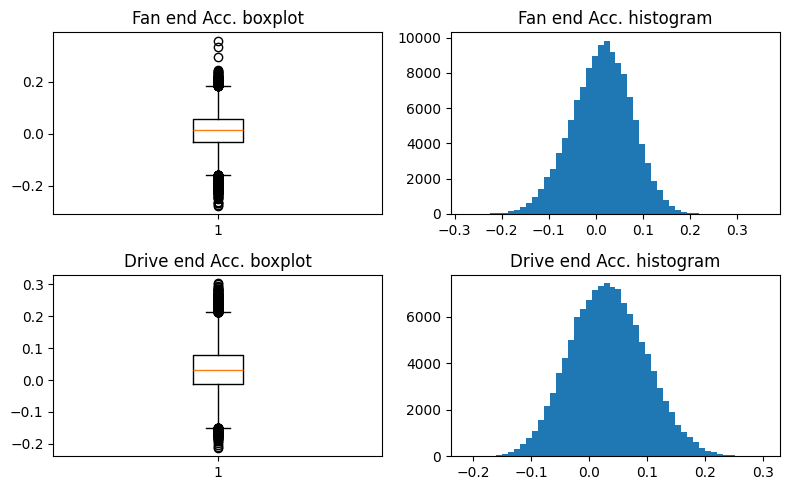

In [146]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
ax[0,0].boxplot(df_normal['FanEndAcc'])
ax[0,0].set_title('Fan end Acc. boxplot')
ax[0,1].hist(df_normal['FanEndAcc'], bins=50)
ax[0,1].set_title('Fan end Acc. histogram')
ax[1,0].boxplot(df_normal['DriveEndAcc'])
ax[1,0].set_title('Drive end Acc. boxplot')
ax[1,1].hist(df_normal['DriveEndAcc'], bins=50)
ax[1,1].set_title('Drive end Acc. histogram')
plt.tight_layout()
plt.show()

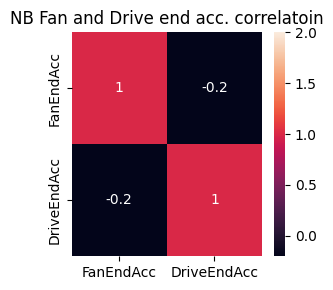

In [147]:
plt.figure(figsize=(3,3))
sns.heatmap(df_normal[['FanEndAcc', 'DriveEndAcc']].corr('pearson'), annot=True, vmax=2)
plt.title('NB Fan and Drive end acc. correlatoin')
plt.tight_layout()
plt.show()


### check duplicates

**Should I Remove Duplicates in an Accelerometer-Based Bearing Fault Dataset?**

***How Do Duplicates Arise?***

*Steady-state signals:* If the system operates under stable conditions, some measurements might appear identical across consecutive timestamps.

*Sensor precision limits:* If sensor resolution is limited, small changes might be rounded, leading to identical readings.

*Sampling effects:* Data might be sampled at a high rate, leading to near-identical readings due to minimal change in vibration levels.

*Data preprocessing issues:* If data has been preprocessed (e.g., resampled, interpolated, or aggregated), duplicates might appear.

***Does Removing Duplicates Affect Fault Detection?***

If the dataset is showing a trend, removing duplicates could be a bad move because:

*Fault evolution might be gradual:* Removing duplicates could eliminate important information about how a fault develops over time.

*Temporal relationships matter:* Vibration patterns in bearings often involve subtle changes over time, which duplicates may represent.

*Pattern recognition models rely on time-series data:* If you plan to use Machine Learning (e.g., CNNs, LSTMs), removing duplicates could disrupt meaningful patterns.


However, if duplicates do not provide new information (e.g., they arise from artifacts of data collection), then removing them might help reduce data size without losing useful signals.

In [148]:
print('number of duplicates in the dataset: ', sum(df_normal.duplicated()))

number of duplicates in the dataset:  6519


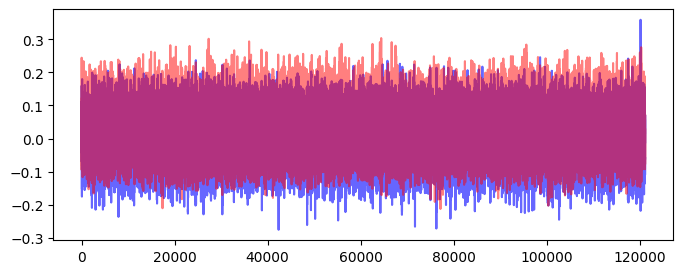

In [149]:
plt.figure(figsize = (8,3))
plt.plot(df_normal.index, df_normal.iloc[:,0], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.plot(df_normal.index, df_normal.iloc[:,1], color='red', alpha=0.5)#FanEnd Acc. is red
plt.show()


instead of removing duplicates lets first understand the duplication pattern and find the possible reason for that.
first I create a column that marks all duplicates. Then a column that marks duplicates by grouping them. In this way I can plot duplicates related to each group and compare them with the data pattern.

In [ ]:
df_normal['duplicated'] = np.where(df_normal.duplicated(subset=signal_columns,keep=False), 1, 0)
df_normal['duplicate_group'] = df_normal[df_normal['duplicated']==1].groupby(['DriveEndAcc', 'FanEndAcc']).ngroup()+1
df_normal['duplicate_group'] = df_normal['duplicate_group'].fillna(0)
df_normal.describe()

,FanEndAcc,DriveEndAcc,fault,duplicated,duplicate_group
count,121155.000000,121155.000000,121155.0,121155.000000,121155.000000
mean,0.011768,0.032724,0.0,0.104915,324.623218
std,0.063400,0.065195,0.0,0.306445,1110.240597
min,-0.275998,-0.213056,0.0,0.000000,0.000000
25%,-0.030249,-0.013355,0.0,0.000000,0.000000
50%,0.014186,0.031024,0.0,0.000000,0.000000
75%,0.056118,0.077045,0.0,0.000000,0.000000
max,0.359236,0.303867,0.0,1.000000,6192.000000


While the numbe rof duplicares is 6519 and the enumber of duplicate groups is 6192, 327 have more than two repeatitions.


In [151]:
df_normal_filtered = df_normal[df_normal['duplicated']==1]
df_normal_filtered.head()

,FanEndAcc,DriveEndAcc,fault,duplicated,duplicate_group
6,0.030249,-0.038625,0,1,582.0
21,-0.010639,0.077045,0,1,5215.0
38,-0.005841,0.170322,0,1,6182.0
47,0.028163,0.081360,0,1,5342.0
51,0.011474,-0.049925,0,1,355.0


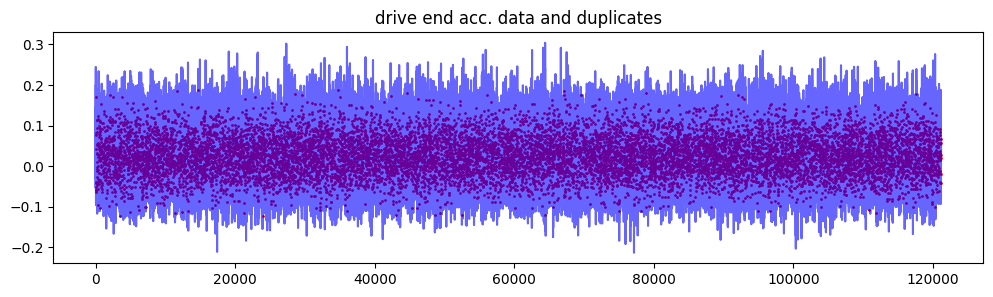

In [152]:
plt.figure(figsize = (12,3))
plt.plot(df_normal.index, df_normal['DriveEndAcc'], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.scatter(df_normal_filtered.index, df_normal_filtered['DriveEndAcc'], color='red', s=1)#Duplicates are red
plt.title('drive end acc. data and duplicates')
plt.show()

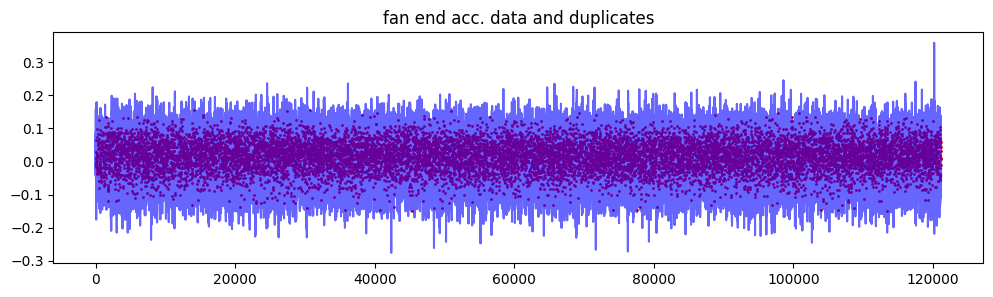

In [153]:
plt.figure(figsize = (12,3))
plt.plot(df_normal.index, df_normal['FanEndAcc'], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.scatter(df_normal_filtered.index, df_normal_filtered['FanEndAcc'], color='red', s=1)#Duplicates are red
plt.title('fan end acc. data and duplicates')
plt.show()

Duplicates look scattered in the plot. Additionally, they also are not at the min or max values of the plot. So we can infer that:

1. duplicates are not due to sensor saturation
2. they probably are not due to drive stall(need more investigation)

but let's do not quit here, we can create a tool to visualize each group!

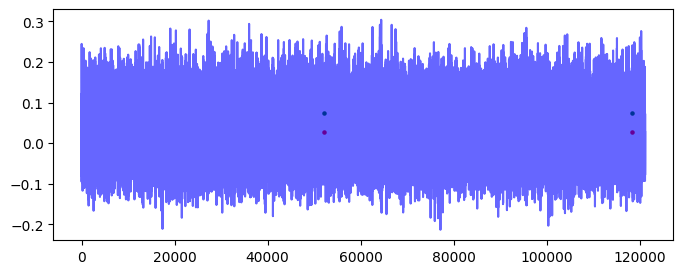

In [161]:
# play with duplicate_group to get a grasp of duplicates
duplicate_group = 3223
plt.figure(figsize = (8,3))
plt.plot(df_normal.index, df_normal['DriveEndAcc'], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.scatter(df_normal[df_normal['duplicate_group']==duplicate_group].index, df_normal[df_normal['duplicate_group']==duplicate_group]['DriveEndAcc'], color='red', s=5)#Duplicates are red
plt.scatter(df_normal[df_normal['duplicate_group']==duplicate_group].index, df_normal[df_normal['duplicate_group']==duplicate_group]['FanEndAcc'], color='green', s=5)#Duplicates are red
plt.show()

This experiment confirms previous results. Since dulicated values are not in consecuitive indexes, they are not due to sensor output saturation or slow output slope (rise time/fall time).
I infer that at least most of the cases are random or injected randomly!

**in case of time series analysis I prefer not to remove duplicates in this dataset.**

**for classifications and any model that does not analyze trend, duplicates should be removed.**

In [88]:
df_normal_with_duplicates = df_normal.iloc[:,[0,1]]
df_normal_without_duplicates = df_normal_with_duplicates.drop_duplicates(subset=signal_columns, keep='first').reset_index(drop=True)

In [89]:
df_normal_without_duplicates

,FanEndAcc,DriveEndAcc
0,0.064254,0.038625
1,0.063002,0.096769
2,-0.004381,0.127382
3,-0.035882,0.144640
4,-0.023991,0.086702
...,...,...
114631,0.035673,0.041296
114632,-0.034630,0.025065
114633,-0.047147,-0.010684
114634,-0.027954,-0.034927


## IR07 fault

In [162]:
df_ir07 = pd.read_csv(data02_path)
df_ir07.head()

,DE,FE
0,-0.093238,-0.029175
1,0.187288,-0.186347
2,0.217663,-0.341260
3,0.070172,-0.160871
4,0.100385,0.179978


In [163]:
signal_columns = {'DriveEndAcc', 'FanEndAcc'}
df_ir07.columns = signal_columns
# since we have two classes we can use 1 for faulti and -1 for normal labels and still prevent ordinal label bias.
# however, one-hot-encoding is also an option which is usually used for more classes
df_ir07['fault'] = 1

### check stats and nulls

In [164]:
print(df_ir07.info())
print(df_ir07.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121155 entries, 0 to 121154
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   FanEndAcc    121155 non-null  float64
 1   DriveEndAcc  121155 non-null  float64
 2   fault        121155 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.8 MB
None
           FanEndAcc    DriveEndAcc     fault
count  121155.000000  121155.000000  121155.0
mean        0.004557       0.033972       1.0
std         0.299474       0.232675       0.0
min        -1.425531      -0.895782       1.0
25%        -0.148872      -0.120602       1.0
50%         0.001299       0.032051       1.0
75%         0.153176       0.187683       1.0
max         1.639620       0.957213       1.0


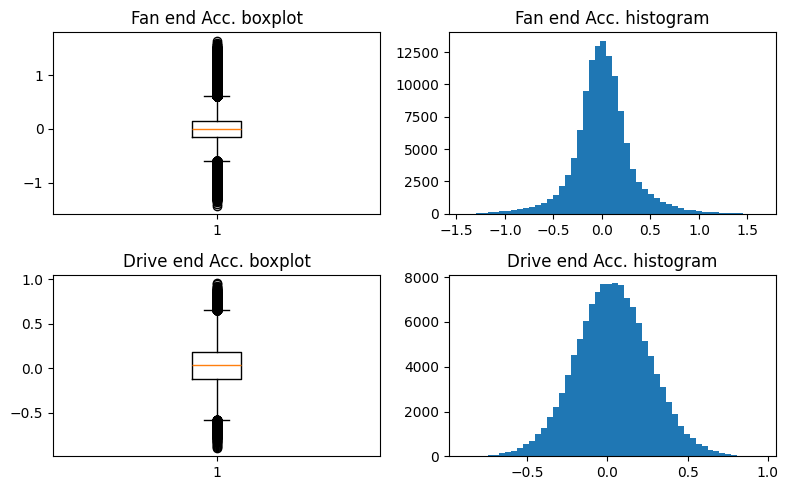

In [166]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
ax[0,0].boxplot(df_ir07['FanEndAcc'])
ax[0,0].set_title('Fan end Acc. boxplot')
ax[0,1].hist(df_ir07['FanEndAcc'], bins=50)
ax[0,1].set_title('Fan end Acc. histogram')
ax[1,0].boxplot(df_ir07['DriveEndAcc'])
ax[1,0].set_title('Drive end Acc. boxplot')
ax[1,1].hist(df_ir07['DriveEndAcc'], bins=50)
ax[1,1].set_title('Drive end Acc. histogram')
plt.tight_layout()
plt.show()

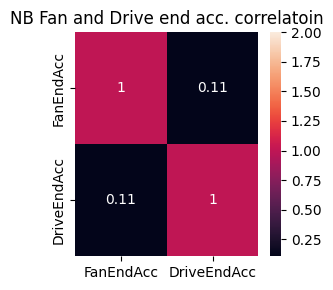

In [167]:
plt.figure(figsize=(3,3))
sns.heatmap(df_ir07[['FanEndAcc', 'DriveEndAcc']].corr('pearson'), annot=True, vmax=2)
plt.title('NB Fan and Drive end acc. correlatoin')
plt.tight_layout()
plt.show()


### check duplicates

**Should I Remove Duplicates in an Accelerometer-Based Bearing Fault Dataset?**

***How Do Duplicates Arise?***

*Steady-state signals:* If the system operates under stable conditions, some measurements might appear identical across consecutive timestamps.

*Sensor precision limits:* If sensor resolution is limited, small changes might be rounded, leading to identical readings.

*Sampling effects:* Data might be sampled at a high rate, leading to near-identical readings due to minimal change in vibration levels.

*Data preprocessing issues:* If data has been preprocessed (e.g., resampled, interpolated, or aggregated), duplicates might appear.

***Does Removing Duplicates Affect Fault Detection?***

If the dataset is showing a trend, removing duplicates could be a bad move because:

*Fault evolution might be gradual:* Removing duplicates could eliminate important information about how a fault develops over time.

*Temporal relationships matter:* Vibration patterns in bearings often involve subtle changes over time, which duplicates may represent.

*Pattern recognition models rely on time-series data:* If you plan to use Machine Learning (e.g., CNNs, LSTMs), removing duplicates could disrupt meaningful patterns.


However, if duplicates do not provide new information (e.g., they arise from artifacts of data collection), then removing them might help reduce data size without losing useful signals.

In [168]:
print('number of duplicates in the dataset: ', sum(df_ir07.duplicated()))

number of duplicates in the dataset:  422


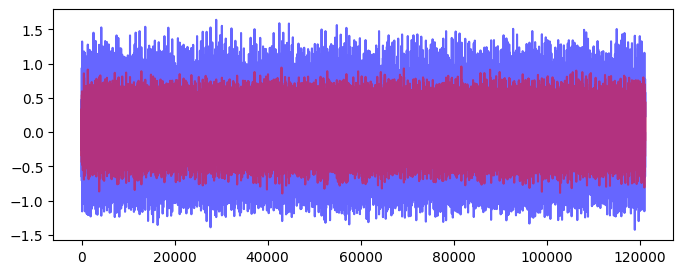

In [169]:
plt.figure(figsize = (8,3))
plt.plot(df_ir07.index, df_ir07.iloc[:,0], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.plot(df_ir07.index, df_ir07.iloc[:,1], color='red', alpha=0.5)#FanEnd Acc. is red
plt.show()


instead of removing duplicates lets first understand the duplication pattern and find the possible reason for that.
first I create a column that marks all duplicates. Then a column that marks duplicates by grouping them. In this way I can plot duplicates related to each group and compare them with the data pattern.

In [170]:
df_ir07['duplicated'] = np.where(df_ir07.duplicated(subset=signal_columns,keep=False), 1, 0)
df_ir07['duplicate_group'] = df_ir07[df_ir07['duplicated']==1].groupby(['DriveEndAcc', 'FanEndAcc']).ngroup()+1
df_ir07['duplicate_group'] = df_ir07['duplicate_group'].fillna(0)
df_ir07.describe()

,FanEndAcc,DriveEndAcc,fault,duplicated,duplicate_group
count,121155.000000,121155.000000,121155.0,121155.000000,121155.000000
mean,0.004557,0.033972,1.0,0.006950,1.464009
std,0.299474,0.232675,0.0,0.083075,20.210904
min,-1.425531,-0.895782,1.0,0.000000,0.000000
25%,-0.148872,-0.120602,1.0,0.000000,0.000000
50%,0.001299,0.032051,1.0,0.000000,0.000000
75%,0.153176,0.187683,1.0,0.000000,0.000000
max,1.639620,0.957213,1.0,1.000000,420.000000


While the numbe rof duplicares is 422 and the enumber of duplicate groups is 420, 2 have more than two repeatitions.


In [171]:
df_ir07_filtered = df_ir07[df_ir07['duplicated']==1]
df_ir07_filtered.head()

,FanEndAcc,DriveEndAcc,fault,duplicated,duplicate_group
459,0.025827,0.051364,1,1,235.0
465,0.002437,-0.134778,1,1,63.0
490,-0.088690,-0.149571,1,1,49.0
564,0.051330,0.305922,1,1,403.0
726,0.161948,0.206687,1,1,361.0


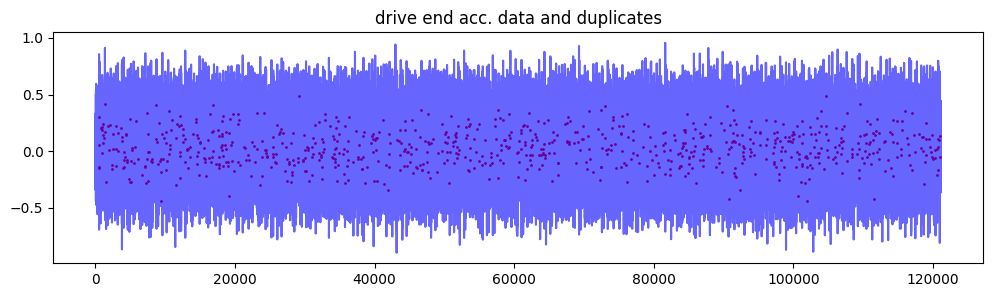

In [172]:
plt.figure(figsize = (12,3))
plt.plot(df_ir07.index, df_ir07['DriveEndAcc'], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.scatter(df_ir07_filtered.index, df_ir07_filtered['DriveEndAcc'], color='red', s=1)#Duplicates are red
plt.title('drive end acc. data and duplicates')
plt.show()

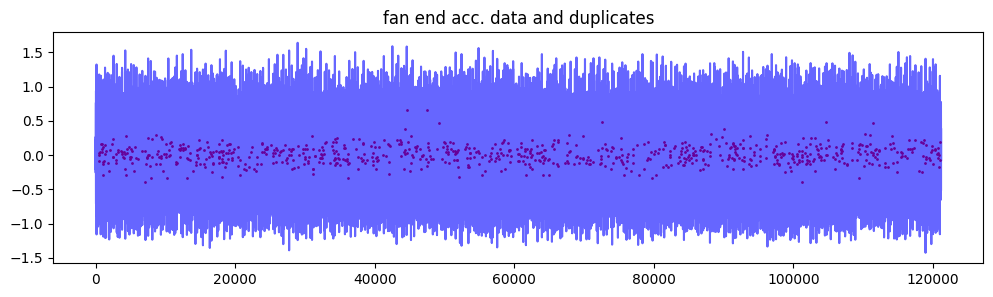

In [173]:
plt.figure(figsize = (12,3))
plt.plot(df_ir07.index, df_ir07['FanEndAcc'], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.scatter(df_ir07_filtered.index, df_ir07_filtered['FanEndAcc'], color='red', s=1)#Duplicates are red
plt.title('fan end acc. data and duplicates')
plt.show()

Duplicates look scattered in the plot. Additionally, they also are not at the min or max values of the plot. So we can infer that:

1. duplicates are not due to sensor saturation
2. they probably are not due to drive stall(need more investigation)

but let's do not quit here, we can create a tool to visualize each group!

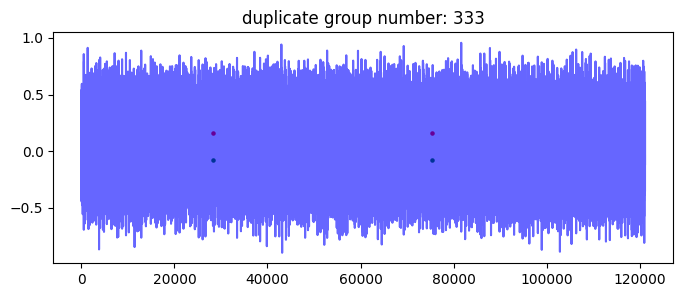

In [191]:
# play with duplicate_group to get a grasp of duplicates
duplicate_group = 333
plt.figure(figsize = (8,3))
plt.plot(df_ir07.index, df_ir07['DriveEndAcc'], color='blue', alpha=0.6)#DriveEnd Acc. is Blue
plt.scatter(df_ir07[df_ir07['duplicate_group']==duplicate_group].index, df_ir07[df_ir07['duplicate_group']==duplicate_group]['DriveEndAcc'], color='red', s=5)#Duplicates are red
plt.scatter(df_ir07[df_ir07['duplicate_group']==duplicate_group].index, df_ir07[df_ir07['duplicate_group']==duplicate_group]['FanEndAcc'], color='green', s=5)#Duplicates are red
plt.title(f"duplicate group number: {duplicate_group}")
plt.show()

This experiment confirms previous results. Since dulicated values are not in consecuitive indexes, they are not due to sensor output saturation or slow output slope (rise time/fall time).
I infer that at least most of the cases are random or injected randomly!

**in case of time series analysis I prefer not to remove duplicates in this dataset.**

**for classifications and any model that does not analyze trend, duplicates should be removed.**

In [192]:
df_ir07_with_duplicates = df_ir07.iloc[:,[0,1]]
df_ir07_without_duplicates = df_ir07_with_duplicates.drop_duplicates(subset=signal_columns, keep='first').reset_index(drop=True)

## IR07 fault

In [33]:
df_ir07 = pd.read_csv(data02_path)
df_ir07.columns = signal_columns
df_ir07['fault'] = 1

In [34]:
df_ir21 = pd.read_csv(data03_path)
df_ir21.columns = signal_columns
df_ir21['fault'] = 2

In [35]:
df_or07 = pd.read_csv(data04_path)
df_or07.columns = signal_columns
df_or07['fault'] = 3

In [36]:
df_or21 = pd.read_csv(data03_path)
df_or21.columns = signal_columns
df_or21['fault'] = 4

In [ ]:
dataset = pd.concat([df_normal, df_ir07, df_ir21, df_or07, df_or21], ignore_index=True)